In [25]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
from DelayControlSystem.delay_control import *

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.family"] = "Times New Roman"

Defination of PID controller class and methods to tune and compute control signals based on error input.

In [ ]:
class PIDController:
    def __init__(self, Kp=1.0, Ki=0.0, Kd=0.0, dt=0.01, N=100):
        self.Kp = np.array(Kp)
        self.Ki = np.array(Ki)
        self.Kd = np.array(Kd)
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
        self.N = N  # Derivative filter coefficient
        self.derivative_filtered = 0.0

    def __call__(self):
        print("The PID controller Gains are")
        print(f"Kp: {self.Kp}, Ki: {self.Ki}, Kd: {self.Kd}")

    def compute(self, setpoint, measurement):
        error = setpoint - measurement
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt if self.dt > 0 else 0.0
        self.derivative_filtered = (
            (self.N * self.dt * derivative + self.derivative_filtered)
            / (self.N * self.dt + 1)
            if hasattr(self, "derivative_filtered")
            else derivative
        )
        output = (
            (self.Kp * error)
            + (self.Ki * self.integral)
            + (self.Kd * self.derivative_filtered)
        )
        self.prev_error = error
        return output

    def reset(self):
        self.integral = 0.0
        self.prev_error = 0.0
        self.derivative_filtered = 0.0

    def update_gains(self, Kp, Ki, Kd):
        self.Kp = np.array(Kp)
        self.Ki = np.array(Ki)
        self.Kd = np.array(Kd)

    # %% IMC-PID Tuning Method for FOPDT Systems with Talyor Series Approximation
    def IMC_tune(self, lambda_c, K, tau, theta):
        K_c = tau / (K * (lambda_c + theta))
        tau_i = tau
        Kp = K_c
        Ki = K_c / tau_i
        Kd = 0.0
        self.update_gains(Kp, Ki, Kd)

<TransferFunction>: sys[22]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    1
  -----
  s + 1


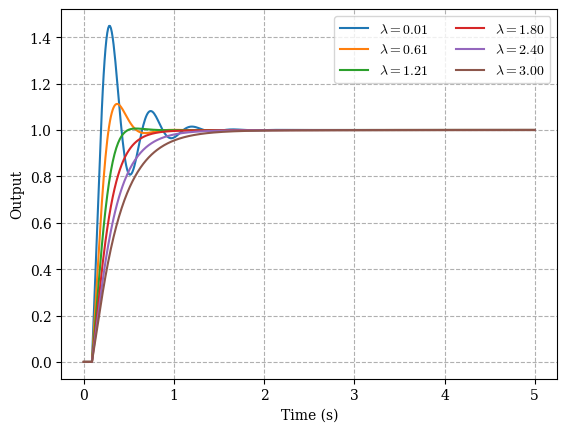

In [ ]:
K = 1
tau = 1
theta = 0.1

G = ctrl.TransferFunction([K], [tau, 1])  # Plant Transfer Function
delay_time = theta  # Delay time in seconds
print(G)
dt = 0.01  # Time step for simulation
time = np.arange(0, 5, dt)  # Simulation time vector

Kp = 1.0
Ki = 1.0
Kd = 0.5

pid = PIDController(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt)
Plant = DelayControlSystem(G, delay_time, dt)
lambda_t = {}
for i, lambda_c in enumerate(np.linspace(0.01, 3, 6)):
    Plant.reset()
    pid.reset()
    for j, _ in enumerate(time):
        setpoint = 1.0  # Desired setpoint
        measurement = Plant.y[-1] if Plant.y else 0.0
        error = setpoint - measurement
        pid.IMC_tune(lambda_c=0.1 * lambda_c, K=K, tau=tau, theta=theta)
        u = pid.compute(setpoint, measurement)
        Plant.step(u)
    plt.plot(Plant.t, Plant.y, label=f"$\\lambda={lambda_c:0.2f}$")

plt.legend(ncol=2)
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.grid(linestyle="--")
plt.show()

Exercise: 

1: Design the methods for all different types of IMC-PID controllers.

2: compare the performance of each controller type using a standard test system.

3: Analyze the results and determine which controller type performs best under various conditions.